# Step 8: Adjusting Model Bias

## Objective

In this step we test several different hypothesis to reduce model Bias. The hypothesis tested were:

* Remove Sensitive Features
* Remove Latitude and Longitude Features
* Remove stations with the highest success rate difference across all classes and keep only the “less biased” ones
    * with sensitive features and Latitude and Longitude
    * with Latitude and Longitude and without sensitive features
    * without sensitive features and Latitude and Longitude

## Findings

Simply removing the sensitive features led to the best results - a recall of 0.821 and an average precision difference of 0.113.


In [1]:
import aux_functions
from app_functions import attempt_predict
from transformers import TimeTransformer2, BoolTransformer, lat_lon_imputer, Group_Age_Range, Group_Ethnicity

import json
import joblib
import pickle
import requests
from time import sleep
import random

import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

# Hypothesis 1: Remove sensitive features

# Get the data

In [2]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']

df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Pipeline Definition

In [3]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('scaler', MinMaxScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)
        ],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Train Model

In [4]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

# columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)


,quarter,year,hour,day of the week,Type,Object of search,Part of a policing operation,Latitude,Longitude
0,0.333333,0.0,0.826087,0.666667,0.54514,0.55516,0.0,0.584645,0.698278
1,0.0,1.0,0.73913,1.0,0.484365,0.55516,0.0,0.252933,0.739332
2,0.333333,0.0,0.652174,0.333333,0.484365,0.55516,0.0,0.511023,0.65343
3,0.0,0.0,0.391304,0.333333,0.484365,0.55516,0.0,0.471838,0.539571
4,0.333333,0.0,0.73913,0.166667,0.54514,0.55516,0.0,0.50235,0.695199
...,...,...,...,...,...,...,...,...,...
98769,0.333333,1.0,0.043478,0.5,0.54514,0.55516,0.0,0.063275,0.40027
98770,0.0,1.0,0.565217,0.166667,0.484365,0.55516,0.0,0.27568,0.777481
98771,1.0,1.0,0.217391,0.333333,0.54514,0.55516,0.0,0.464807,0.526711
98772,1.0,1.0,0.695652,0.833333,0.484365,0.331967,0.0,0.659453,0.522612


# Predict

In [5]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate

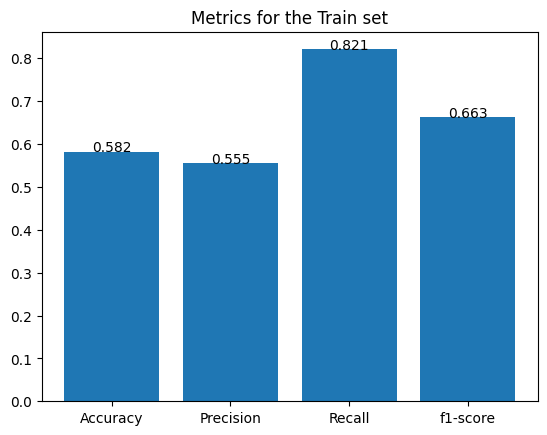

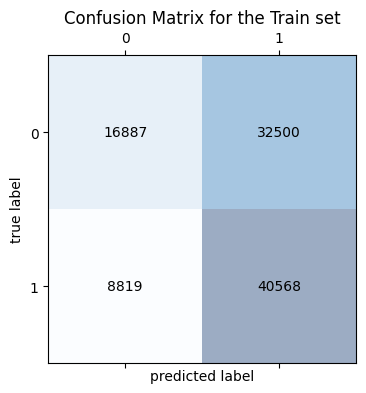

In [6]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

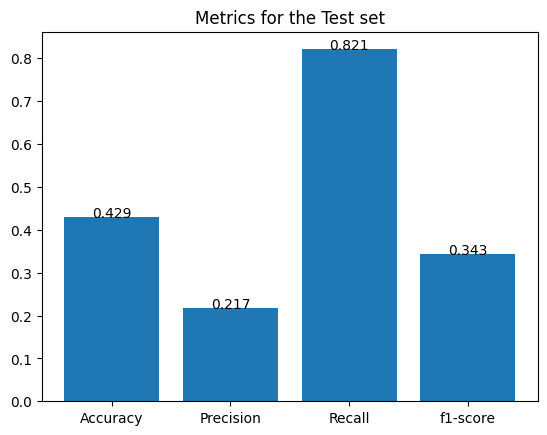

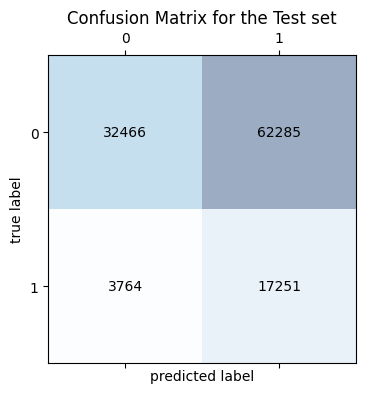

In [7]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

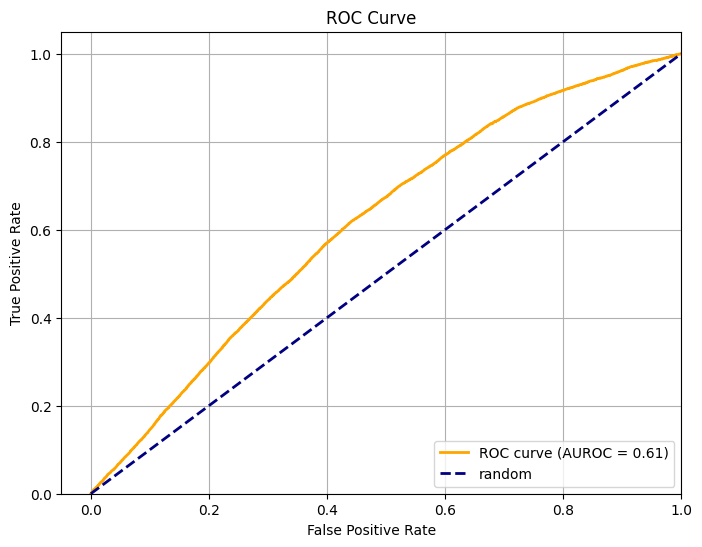

In [8]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

Recall requirement: (True, 0.8208898405900548)


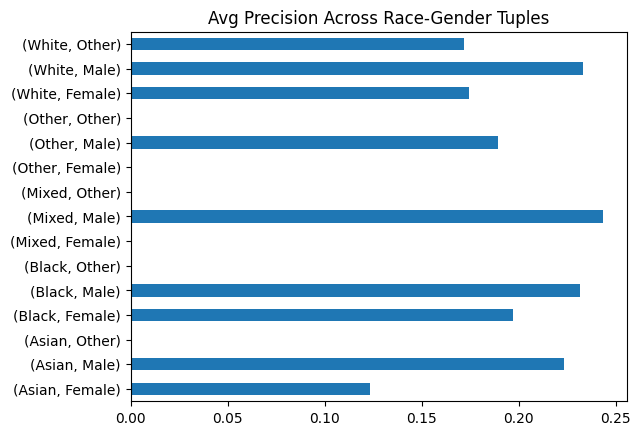

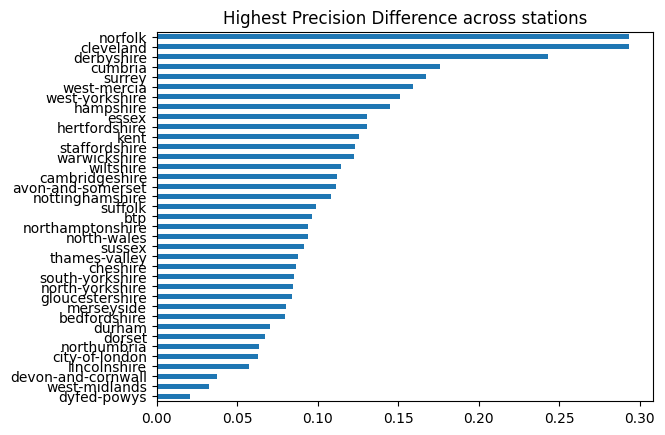

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.2330480811451127, ('White', 'Female'): 0.17456437967964242, ('White', 'Other'): 0.17152961980548187, ('Black', 'Male'): 0.2316144040589281, ('Black', 'Female'): 0.19675914533069475, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.22312640411031176, ('Asian', 'Female'): 0.12322894273988666, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.2434262027177585, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.18930423792049386, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 34
Num good departments: 3
avg diff: 0.11300108108108109


In [9]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

# Hypothesis 2: Remove stations with highest avg difference from training data

# Get the data

In [10]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']


df_clean = aux_functions.clean_data(df_, drop_cols)

# df_clean = df_clean[(df_clean["station"].isin(['kent','durham','city-of-london','west-mercia','cheshire','derbyshire','btp','northumbria','cleveland','warwickshire']) & 
#           (df_clean['Gender'] != 'Other') &
#           (df_clean['Age range'] != 'under 10') &
#           (df_clean['Officer-defined ethnicity'] != 'Mixed'))].copy()

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

good_stations = ['sussex',
 'south-yorkshire',
 'warwickshire',
 'devon-and-cornwall',
 'thames-valley',
 'lincolnshire',
 'kent',
 'west-mercia',
 'btp',
 'hertfordshire',
 'west-yorkshire',
 'cleveland',
 'dyfed-powys',
 'west-midlands',
 'merseyside']

df_train = df_train[(df_train["station"].isin(good_stations))].copy()

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Pipeline Definition

In [11]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    ordered_col = ['Age range']

    categorical_cols = ['Type', 'Gender', 'Officer-defined ethnicity', 'Object of search']

    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    # Define ordered pipeline
    ordered_pipe = Pipeline([
            ('group_age_range', Group_Age_Range()),
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(categories=[['under 17', '18-24', '25-34', 'over 34']] ,handle_unknown='use_encoded_value', unknown_value=-1)),
            ('scaler', MinMaxScaler())
        ])
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('group_ethnicity', Group_Ethnicity()),
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('imputer_2', SimpleImputer()),
            ('scaler', MinMaxScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('ord', ordered_pipe, ordered_col),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Train Model

In [12]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'year', 'hour', 'day of the week', 'Age range', 'Type', 'Gender', 'Officer-defined ethnicity', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)


,quarter,year,hour,day of the week,Age range,Type,Gender,Officer-defined ethnicity,Object of search,Part of a policing operation,Latitude,Longitude
0,0.333333,1.0,0.913043,0.666667,0.333333,0.561424,0.503792,0.500659,0.551858,0.0,0.464501,0.537642
1,0.333333,1.0,0.043478,1.0,0.666667,0.469699,0.503792,0.500659,0.551858,0.0,0.471719,0.529218
2,0.333333,1.0,0.956522,0.166667,0.666667,0.561424,0.503792,0.500659,0.551858,0.0,0.163055,0.988309
3,1.0,1.0,0.478261,0.5,0.0,0.561424,0.503792,0.500659,0.551858,0.0,0.174439,0.9017
4,0.0,0.0,0.956522,0.0,1.0,0.469699,0.503792,0.500659,0.335389,0.0,0.459833,0.540817
...,...,...,...,...,...,...,...,...,...,...,...,...
51897,0.0,0.0,0.391304,0.666667,0.666667,0.469699,0.503792,0.500659,0.551858,0.0,0.462402,0.538168
51898,1.0,1.0,0.434783,0.0,0.666667,0.469699,0.503792,0.500659,0.551858,0.0,0.371099,0.558076
51899,0.333333,1.0,0.043478,0.5,0.666667,0.561424,0.503792,0.500659,0.551858,0.0,0.063275,0.41232
51900,1.0,1.0,0.217391,0.333333,1.0,0.561424,0.503792,0.500659,0.551858,0.0,0.464807,0.543106


# Predict

In [13]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate

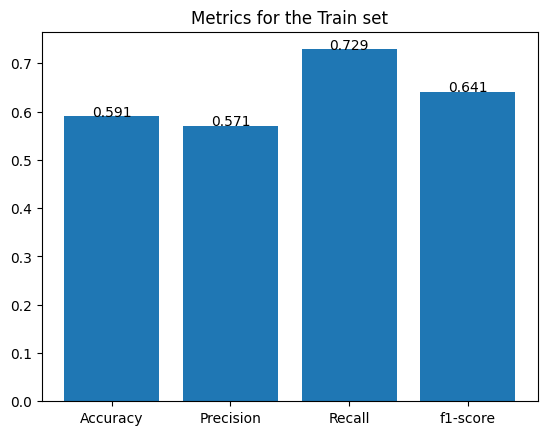

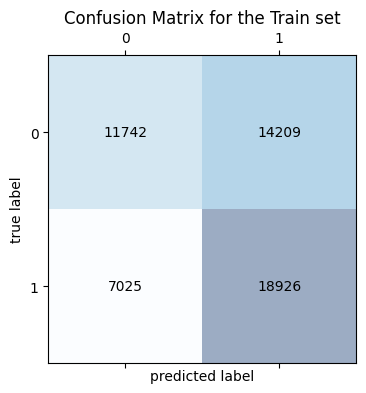

In [14]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

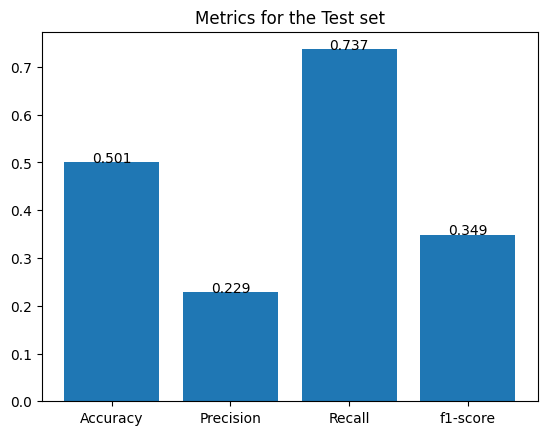

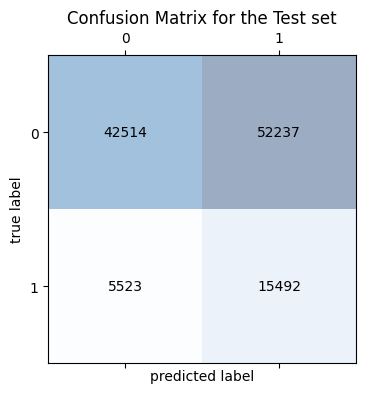

In [15]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

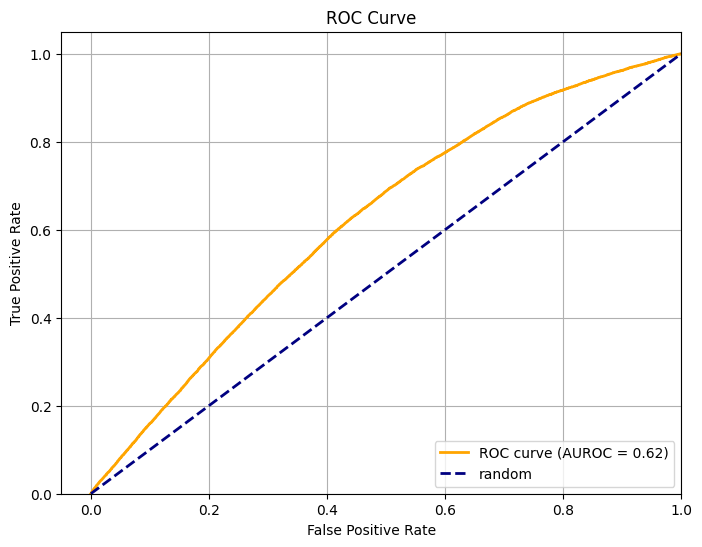

In [16]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

Recall requirement: (False, 0.7371877230549607)


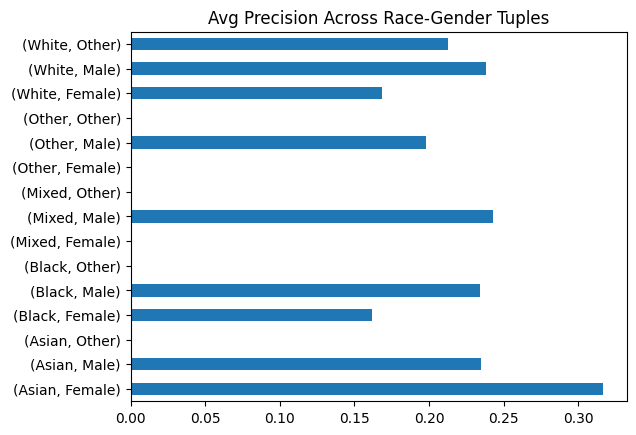

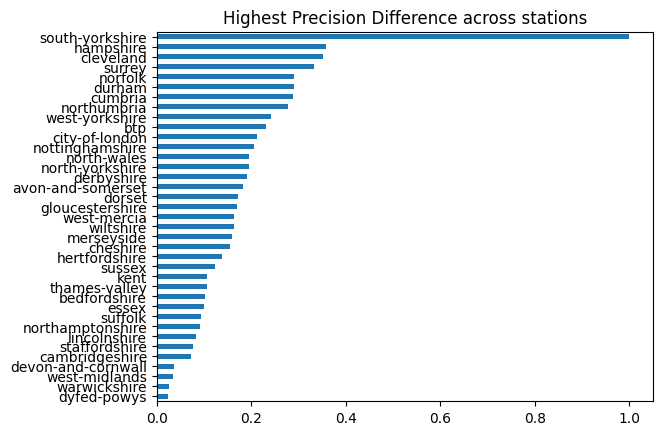

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.23803684778919607, ('White', 'Female'): 0.16857121694561444, ('White', 'Other'): 0.2129032258064516, ('Black', 'Male'): 0.2339636636718311, ('Black', 'Female'): 0.1614168247944339, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.23456176799050024, ('Asian', 'Female'): 0.31666666666666665, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.24289943775477282, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.19802086754073808, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 33
Num good departments: 4
avg diff: 0.1905310810810811


In [17]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

# Hypothesis 3: Remove stations with highest avg difference from training data and Sensitive Features

# Get the data

In [18]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']


df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

#keep only stations with low bias

good_stations = ['sussex',
 'south-yorkshire',
 'warwickshire',
 'devon-and-cornwall',
 'thames-valley',
 'lincolnshire',
 'kent',
 'west-mercia',
 'btp',
 'hertfordshire',
 'west-yorkshire',
 'cleveland',
 'dyfed-powys',
 'west-midlands',
 'merseyside']

df_train = df_train[(df_train["station"].isin(good_stations))].copy()

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Pipeline Definition

In [19]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude', 'station'] # station is needed for NaN imputing

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', lat_lon_imputer()),
            ('imputer_2', SimpleImputer()),
            ('scaler', MinMaxScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Train Model

In [20]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation', 'Latitude', 'Longitude']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)


,quarter,year,hour,day of the week,Type,Object of search,Part of a policing operation,Latitude,Longitude
0,0.333333,1.0,0.913043,0.666667,0.561424,0.551858,0.0,0.464501,0.537642
1,0.333333,1.0,0.043478,1.0,0.469699,0.551858,0.0,0.471719,0.529218
2,0.333333,1.0,0.956522,0.166667,0.561424,0.551858,0.0,0.163055,0.988309
3,1.0,1.0,0.478261,0.5,0.561424,0.551858,0.0,0.174439,0.9017
4,0.0,0.0,0.956522,0.0,0.469699,0.335389,0.0,0.459833,0.540817
...,...,...,...,...,...,...,...,...,...
51897,0.0,0.0,0.391304,0.666667,0.469699,0.551858,0.0,0.462402,0.538168
51898,1.0,1.0,0.434783,0.0,0.469699,0.551858,0.0,0.371099,0.558076
51899,0.333333,1.0,0.043478,0.5,0.561424,0.551858,0.0,0.063275,0.41232
51900,1.0,1.0,0.217391,0.333333,0.561424,0.551858,0.0,0.464807,0.543106


# Predict

In [21]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate

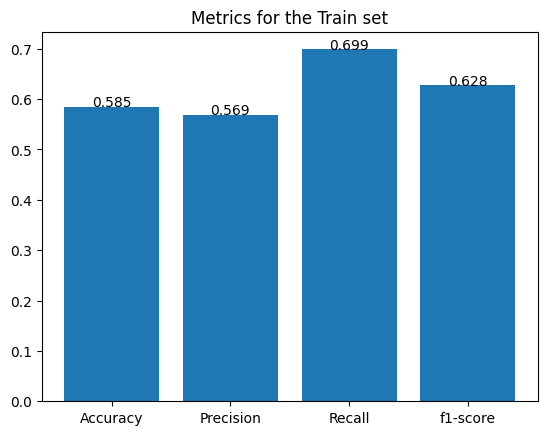

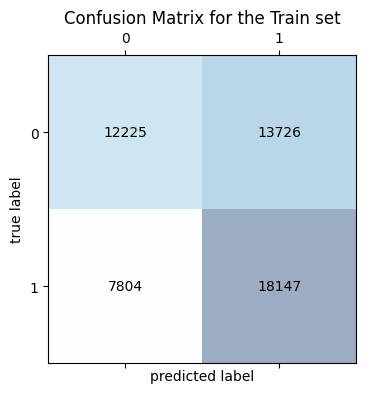

In [22]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

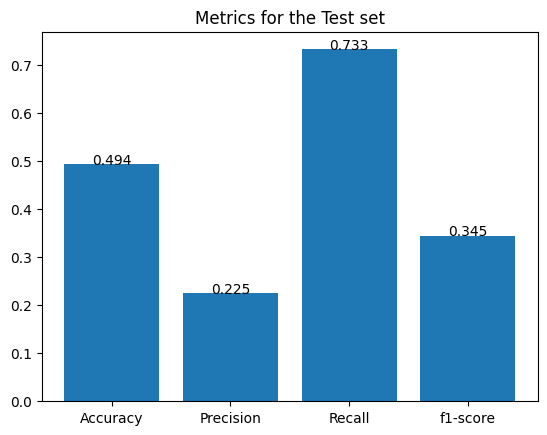

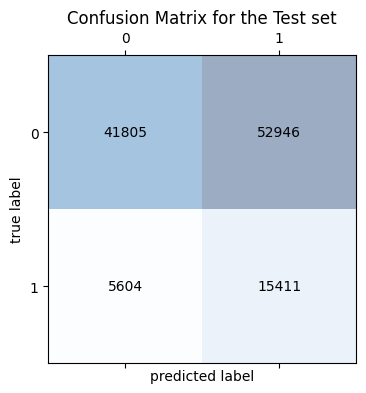

In [23]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

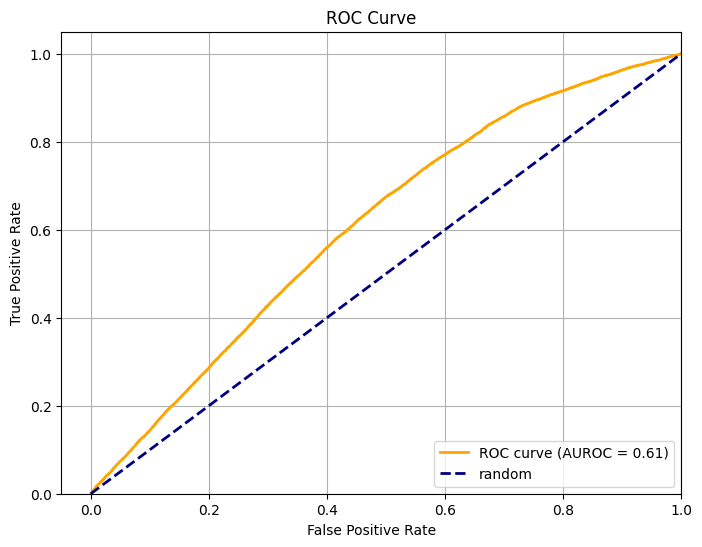

In [24]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

Recall requirement: (False, 0.7333333333333333)


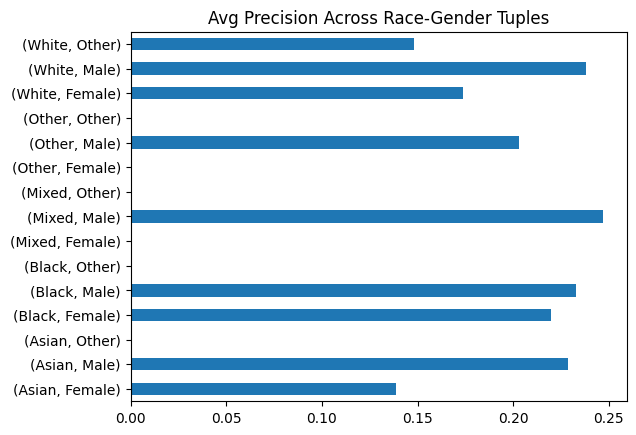

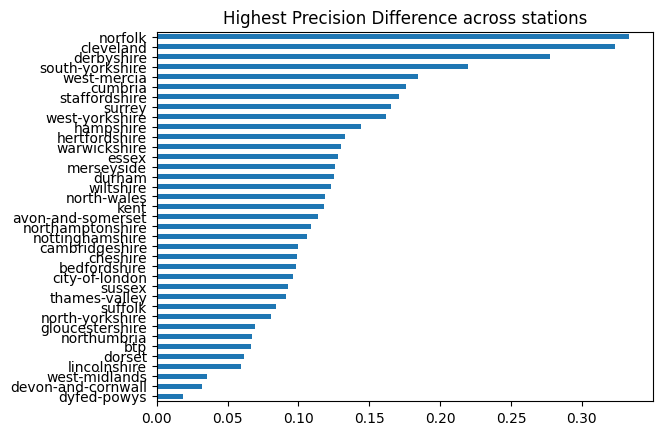

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.23833271868268305, ('White', 'Female'): 0.17396885693134703, ('White', 'Other'): 0.14814814814814814, ('Black', 'Male'): 0.2331274382197062, ('Black', 'Female'): 0.21995464852607707, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.22848613448738636, ('Asian', 'Female'): 0.1389733086680761, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.2470739866512601, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.20302369510997065, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 34
Num good departments: 3
avg diff: 0.12532756756756755


In [25]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

# Hypothesis 4: Remove stations with highest avg difference from training data and Sensitive Features and Lat/Long

# Get the data

In [26]:
df_ = pd.read_csv("data/train.csv")

drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']


df_clean = aux_functions.clean_data(df_, drop_cols)

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

#keep only stations with low bias

good_stations = ['sussex',
 'south-yorkshire',
 'warwickshire',
 'devon-and-cornwall',
 'thames-valley',
 'lincolnshire',
 'kent',
 'west-mercia',
 'btp',
 'hertfordshire',
 'west-yorkshire',
 'cleveland',
 'dyfed-powys',
 'west-midlands',
 'merseyside']

df_train = df_train[(df_train["station"].isin(good_stations))].copy()

df_test.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
537261,7178a97c-4228-4d89-bbb8-f957b7888823,Person search,2021-08-21T04:20:00+00:00,False,NaN,NaN,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,south-yorkshire,0
696508,2fa0c965-c196-4a2a-bfa3-645b359ca46f,Person search,2020-05-25T17:12:00+00:00,<NA>,50.811679,-1.083062,Male,10-17,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire,0
109550,4621404c-8b8d-4167-93ea-78a2d95d8195,Person search,2021-02-05T19:22:00+00:00,False,NaN,NaN,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1
609848,2b2f6f9d-651e-4d3c-a3a7-a2bc91e721eb,Person search,2020-07-26T13:00:00+00:00,<NA>,53.182283,-3.423552,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,north-wales,0
247836,af52a1fc-66ab-4225-95b3-6f31d236f687,Person search,2020-09-10T23:00:00+00:00,False,50.875152,0.011468,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0


# Pipeline Definition

In [27]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()


    time_cols = ['Date']

    categorical_cols = ['Type', 'Object of search']
    
    bool_cols = ['Part of a policing operation']


    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer2()),
            ('scaler', MinMaxScaler())
        ])
    
    
    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', TargetEncoder(handle_unknown='value', min_samples_leaf=20 , smoothing=10))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            ('bool_transformer', BoolTransformer())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    pipeline.fit(X_resampled, np.ravel(y_resampled))
    # pipeline.fit(X, np.ravel(y))


    return pipeline, X_resampled, y_resampled
    # return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    prec_scores = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(prec_scores)

# Train Model

In [28]:
# Check transformed data

model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)

columns = ['quarter', 'year', 'hour', 'day of the week', 'Type', 'Object of search', 'Part of a policing operation']

pd.DataFrame(data=pipeline.named_steps["preprocessor"].transform(X_train), columns=columns)


,quarter,year,hour,day of the week,Type,Object of search,Part of a policing operation
0,0.333333,1.0,0.913043,0.666667,0.561424,0.551858,0.0
1,0.333333,1.0,0.043478,1.0,0.469699,0.551858,0.0
2,0.333333,1.0,0.956522,0.166667,0.561424,0.551858,0.0
3,1.0,1.0,0.478261,0.5,0.561424,0.551858,0.0
4,0.0,0.0,0.956522,0.0,0.469699,0.335389,0.0
...,...,...,...,...,...,...,...
51897,0.0,0.0,0.391304,0.666667,0.469699,0.551858,0.0
51898,1.0,1.0,0.434783,0.0,0.469699,0.551858,0.0
51899,0.333333,1.0,0.043478,0.5,0.561424,0.551858,0.0
51900,1.0,1.0,0.217391,0.333333,0.561424,0.551858,0.0


# Predict

In [29]:
# use the pipeline and get predictions and probas

# TEST SET

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
# get the probas
y_proba_test = pipeline.predict_proba(X_test)

# Evaluate

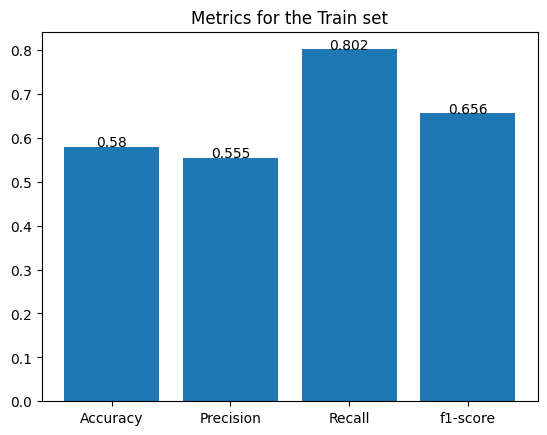

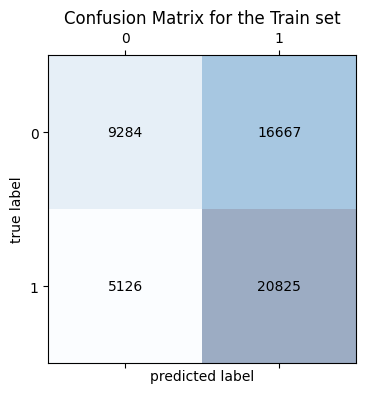

In [30]:
# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

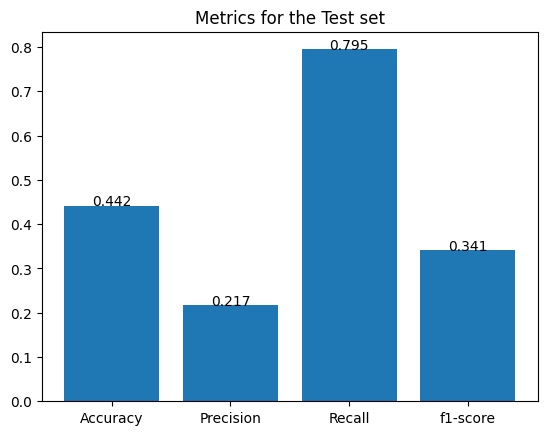

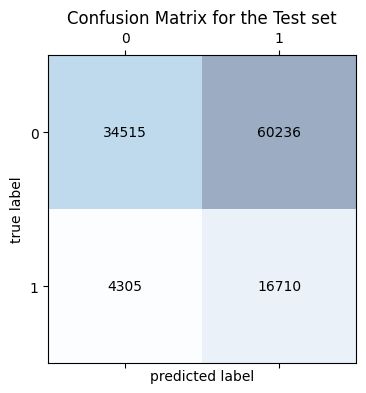

In [31]:
# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred_test)

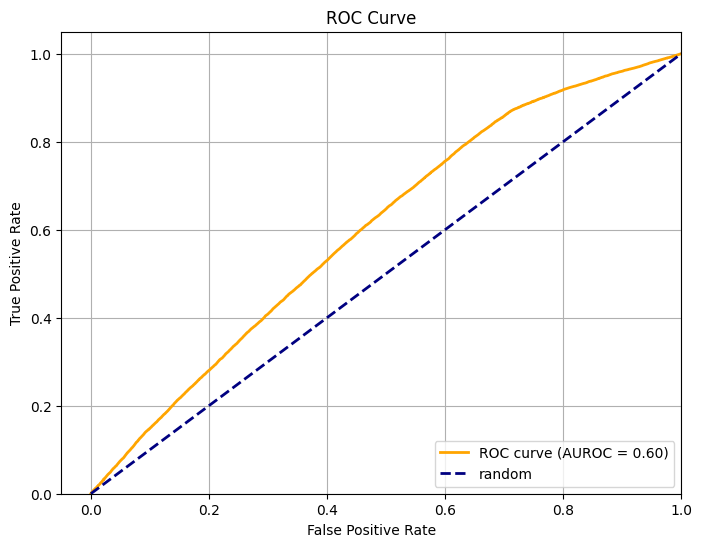

In [32]:
# show roc_curve

aux_functions.plot_roc_curve(y_test, y_proba_test)

Recall requirement: (False, 0.795146324054247)


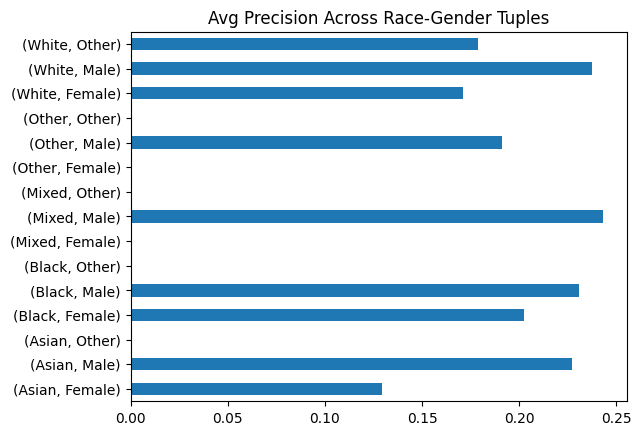

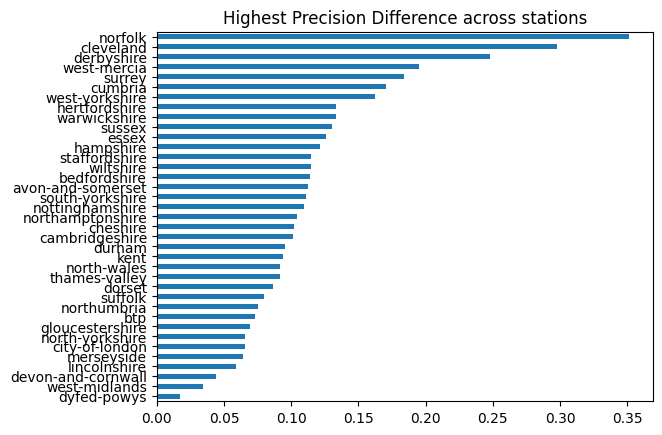

Discrimination requirement
Requirement failed
Global rates: {('White', 'Male'): 0.23728120308368578, ('White', 'Female'): 0.17087945550931974, ('White', 'Other'): 0.17857142857142855, ('Black', 'Male'): 0.2305466467855617, ('Black', 'Female'): 0.20256410256410257, ('Black', 'Other'): nan, ('Asian', 'Male'): 0.2271144772462241, ('Asian', 'Female'): 0.12924865831842577, ('Asian', 'Other'): nan, ('Mixed', 'Male'): 0.243148555230847, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan, ('Other', 'Male'): 0.19133909917782066, ('Other', 'Female'): nan, ('Other', 'Other'): nan}
Num problematic departments: 34
Num good departments: 3
avg diff: 0.11743486486486486


In [33]:
# Check client success rate req

print("Recall requirement: {}".format(aux_functions.verify_success_rate(y_test, y_pred_test, min_success_rate=0.8)))

is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(X_test, y_test, y_pred_test)

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")